In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from PIL import Image
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch
from albumentations.pytorch import ToTensorV2

torch.cuda.empty_cache()

Constants

In [43]:
epoch = 110
batch_size = 42
h = 512
w = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device("cuda:1")

In [44]:
class MyDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.masks_dir = masks_dir
        self.transform = transform
        self.images_dir = images_dir

        self.images_name = os.listdir(images_dir)

    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_name = self.images_name[idx]
        image_path = os.path.join(self.images_dir, image_name)
        mask_path = os.path.join(self.masks_dir, image_name)
        image = cv2.imread(image_path)[:, :, ::-1]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"].unsqueeze(0)
        return image, mask / 255

In [45]:
train_transform = A.Compose([
    A.Resize(height=h, width=w),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True)
])
val_transform = A.Compose([
    A.Resize(height=h, width=w),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True)
])

In [46]:
train_images_path = '/home/a.kalugina2/projects/segm/dataset/train/images'
train_masks_path = '/home/a.kalugina2/projects/segm/dataset/train/masks'

test_images_path = '/home/a.kalugina2/projects/segm/dataset/val/images'
test_masks_path = '/home/a.kalugina2/projects/segm/dataset/val/masks'

train_dataset = MyDataset(train_images_path, train_masks_path, transform=train_transform)
val_dataset = MyDataset(test_images_path, test_masks_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Create model

In [47]:
model = smp.Unet(encoder_name='resnet18', encoder_weights='imagenet', classes=1, activation='sigmoid').to(device)
loss = smp.utils.losses.JaccardLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
metrics = [smp.utils.metrics.IoU(threshold=0.5)]

Train and Test

In [48]:
train_epoch = TrainEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

test_epoch = ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True,
)
epochs = epoch
train_loss = []
train_iou = []
test_loss = []
test_iou = []

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    train_logs = train_epoch.run(train_loader)
    train_loss.append(train_logs['jaccard_loss'])
    train_iou.append(train_logs['iou_score'])

    test_logs = test_epoch.run(test_loader)
    test_loss.append(test_logs['jaccard_loss'])
    test_iou.append(test_logs['iou_score'])


    print(f'Train Logs: {train_logs}')
    print(f'Test Logs: {test_logs}')


Epoch 1/110
valid: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s, jaccard_loss - 0.9372, iou_score - 0.01505]
Train Logs: {'jaccard_loss': 0.9609176516532898, 'iou_score': 0.03487567603588104}
Test Logs: {'jaccard_loss': 0.9372239708900452, 'iou_score': 0.015050273388624191}
Epoch 2/110
valid: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s, jaccard_loss - 0.9314, iou_score - 0.1455]
Train Logs: {'jaccard_loss': 0.9484957456588745, 'iou_score': 0.07419098168611526}
Test Logs: {'jaccard_loss': 0.9313734769821167, 'iou_score': 0.14549040794372559}
Epoch 3/110
valid: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s, jaccard_loss - 0.9175, iou_score - 0.2435]
Train Logs: {'jaccard_loss': 0.9351283311843872, 'iou_score': 0.11765601485967636}
Test Logs: {'jaccard_loss': 0.9174941778182983, 'iou_score': 0.24354849755764008}
Epoch 4/110
valid: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s, jaccard_loss - 0.9035, iou_score - 0.233]
Train Logs: {'jaccard_loss': 0.9248068332672119, 'iou_score': 0.14835682

Graphs Loss anf IoU

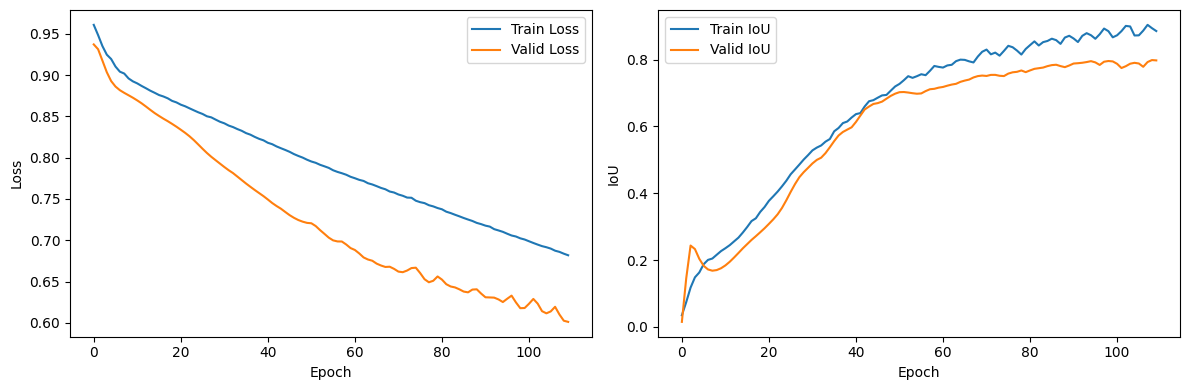

In [49]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iou, label='Train IoU')
plt.plot(test_iou, label='Valid IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

Show the result

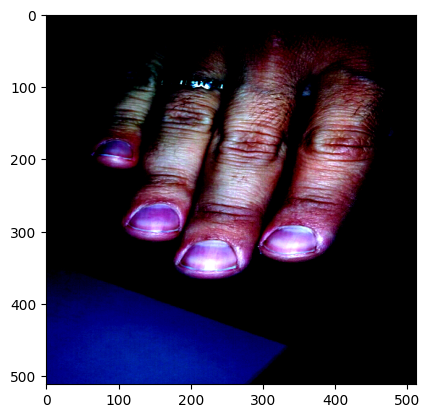

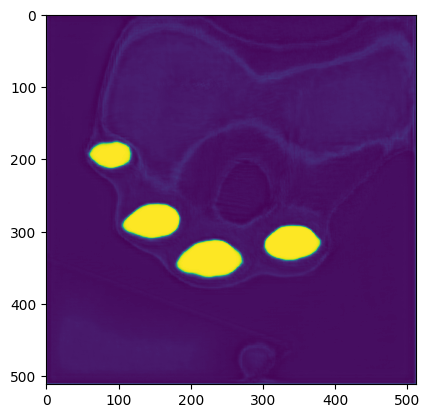

In [50]:
img = val_dataset[5][0].unsqueeze(0)
pred = model(img.cuda(1))
pred = torch.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1, 2, 0)

img_np = img.detach().cpu().numpy()[0].transpose(1, 2, 0)
plt.imshow(img_np)
plt.show()

plt.imshow(pred)

plt.show()

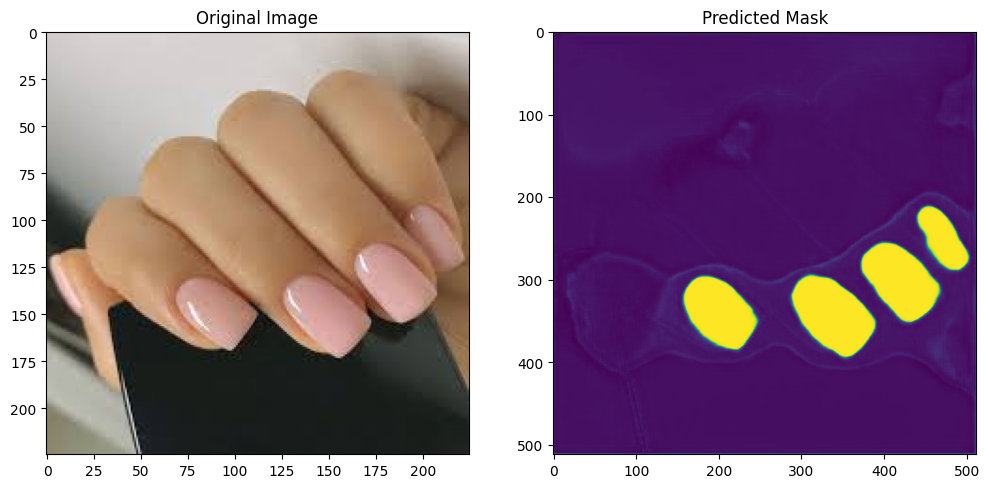

In [51]:
from PIL import Image
def prediction(img_path, transformer):
    image = Image.open(img_path).convert('RGB')
    image_np = np.array(image)
    transformed = transformer(image=image_np)
    image_tensor = transformed['image'].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = torch.sigmoid(output).cpu().numpy()[0][0]  # Assuming binary segmentation

    return pred_mask

image_path='/home/a.kalugina2/projects/segm/images.jpg'
img = Image.open(image_path).convert('RGB')
pred_mask=prediction(image_path, val_transform)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask)
plt.title("Predicted Mask")

plt.show()